In [1]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import os

# Define the path for the CSV file
csv_path = "men_manual_check_dataset.csv"

# Check if the CSV file exists; if not, create it with game IDs from 0 to 945
if not os.path.exists(csv_path):
    print(f"CSV file '{csv_path}' not found. Creating a new file...")
    data = pd.DataFrame({
        "index": range(0, 946),
        "dataset_name": ["men_imbalanced"] * 946,
        "ball_flying_issue": [None] * 946,
        "player_number_issue": [None] * 946,
        "success_label_issue": [None] * 946,
        "comments": [None] * 946,
        "manual_check_passed": [None] * 946
    })
    data.to_csv(csv_path, index=False)
else:
    data = pd.read_csv(csv_path)

# Global variables
current_start_index = 0
rows_per_page = 10

# Create an Output widget
output_area = widgets.Output()

# Helper function to create toggle buttons with color feedback
def create_issue_buttons(row):

    def create_toggle(description, value):
        button = widgets.ToggleButton(
            value=(value == "X"),
            description=description,
            button_style='danger' if value == "X" else ''  # Red if marked with "X"
        )
        button.observe(on_toggle_change, names='value')
        return button

    buttons = {
        "ball_flying_issue": create_toggle("Ball Flying Issue", row["ball_flying_issue"]),
        "player_number_issue": create_toggle("Player Number Issue", row["player_number_issue"]),
        "success_label_issue": create_toggle("Success Label Issue", row["success_label_issue"]),
        "comments": widgets.Text(
            value=str(row["comments"]) if pd.notna(row["comments"]) else "",
            placeholder="Add comments"
        ),
        "manual_check_passed": widgets.ToggleButton(
            value=(row["manual_check_passed"] == "Green"),
            description="Check Passed",
            button_style='success' if row["manual_check_passed"] == "Green" else ''
        )
    }
    buttons["manual_check_passed"].observe(on_manual_check_toggle, names='value')
    return buttons

# Function to handle the manual check button toggle
def on_manual_check_toggle(change):
    button = change.owner
    if change.new:  # If the button is clicked (value is True)
        button.button_style = 'success'
        button.value = True
    else:  # If clicked again (value is False)
        button.button_style = ''
        button.value = False

# Update button color when toggled for issue buttons
def on_toggle_change(change):
    button = change.owner
    button.button_style = 'danger' if button.value else ''

# Store the widgets for the current page
widgets_list = []

# Function to display rows based on the current index
def display_rows(current_start_index):
    global widgets_list
    widgets_list = []

    # Clear the output area
    with output_area:
        output_area.clear_output()
        # Prepare the rows for display
        rows = []
        for i in range(current_start_index, min(current_start_index + rows_per_page, len(data))):
            row = data.iloc[i]
            buttons = create_issue_buttons(row)
            widgets_list.append((i, buttons))
            label_text = f"ID: {row['index']} | Dataset: {row['dataset_name']}"

            row_widgets = widgets.HBox([
                widgets.Label(label_text),
                buttons["ball_flying_issue"],
                buttons["player_number_issue"],
                buttons["success_label_issue"],
                buttons["comments"],
                buttons["manual_check_passed"]
            ])
            rows.append(row_widgets)
        # Display the rows within the output area
        display(*rows)

# Function to save annotations for the current page
def save_annotations():
    for i, buttons in widgets_list:
        data.loc[i, "ball_flying_issue"] = "X" if buttons["ball_flying_issue"].value else None
        data.loc[i, "player_number_issue"] = "X" if buttons["player_number_issue"].value else None
        data.loc[i, "success_label_issue"] = "X" if buttons["success_label_issue"].value else None
        data.loc[i, "comments"] = buttons["comments"].value
        data.loc[i, "manual_check_passed"] = "Green" if buttons["manual_check_passed"].value else "Red"

# Button click event handlers
def on_next_clicked(b):
    global current_start_index
    save_annotations()
    if current_start_index + rows_per_page < len(data):
        current_start_index += rows_per_page
    update_dropdown()
    display_rows(current_start_index)

def on_prev_clicked(b):
    global current_start_index
    save_annotations()
    if current_start_index - rows_per_page >= 0:
        current_start_index -= rows_per_page
    update_dropdown()
    display_rows(current_start_index)

def on_dropdown_change(change):
    global current_start_index
    save_annotations()
    current_start_index = change.new * rows_per_page
    display_rows(current_start_index)

# Initialize navigation and save buttons
next_button = widgets.Button(description="▶️ Next", button_style='success')
prev_button = widgets.Button(description="◀️ Previous", button_style='info')
save_button = widgets.Button(description="Save to CSV", button_style='warning')

next_button.on_click(on_next_clicked)
prev_button.on_click(on_prev_clicked)
save_button.on_click(lambda x: save_to_csv())

# Initialize dropdown for ID navigation
dropdown = widgets.Dropdown(
    options=[(f"Rows {i}-{min(i + rows_per_page - 1, len(data)-1)}", i // rows_per_page) for i in range(0, len(data), rows_per_page)],
    value=0,
    description="Navigate:",
)
dropdown.observe(on_dropdown_change, names='value')

# Function to update the dropdown value based on current index
def update_dropdown():
    dropdown.value = current_start_index // rows_per_page

# Function to save the annotated data
def save_to_csv():
    save_annotations()
    data.to_csv(csv_path, index=False)
    print(f"Annotations saved to '{csv_path}'")

# Display initial UI and the first set of rows
display(widgets.HBox([prev_button, next_button, dropdown, save_button]))
display(output_area)

display_rows(current_start_index)

Output()

/var/folders/9d/wzfpl93x5zb1rrt2jm2wtp300000gn/T/ipykernel_23502/4083754877.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_matrix = data[:50][issue_columns].applymap(lambda x: 1 if x == "X" else 0)


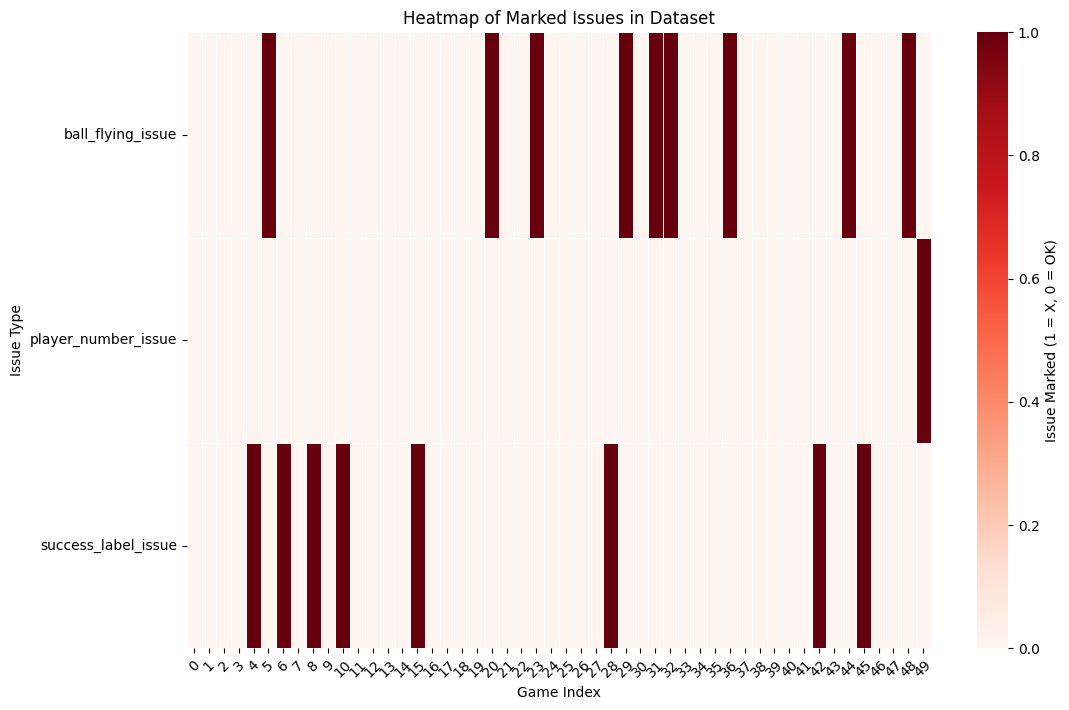

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the annotated CSV file
csv_path = "experiments/men_manual_check_dataset.csv"
data = pd.read_csv(csv_path)

# Define a function to visualize mistakes with a heatmap
def visualize_mistakes_heatmap(data):
    # Define columns with potential issues
    issue_columns = ["ball_flying_issue", "player_number_issue", "success_label_issue"]
    
    # Create a binary matrix (1 if marked with "X", 0 otherwise)
    binary_matrix = data[:50][issue_columns].applymap(lambda x: 1 if x == "X" else 0)
    
    # Calculate the sum of issues per game ID
    issue_summary = binary_matrix.sum(axis=1)

    # Create a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(binary_matrix.T, cmap="Reds", cbar_kws={'label': 'Issue Marked (1 = X, 0 = OK)'}, linewidths=0.5)
    plt.title("Heatmap of Marked Issues in Dataset")
    plt.xlabel("Game Index")
    plt.ylabel("Issue Type")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

    # # Print the filtered DataFrame with marked issues
    # mistakes_df = data[(data[issue_columns] == "X").any(axis=1)]
    # print("Mistakes DataFrame:")
    # print(mistakes_df)

# Call the function
visualize_mistakes_heatmap(data)
